**Processing PEER-AT2 format files as input time histories for dynamic analyses in FLACv8.1**  
Author: William Z. Zakka, UC Berkeley

*Ground motions recorded at the surface for shallows crustal earthquakes in active tectonic regimes can be obtained from the PEER NGA-West2 ground motions database: https://ngawest2.berkeley.edu/. This notebook provides guidance to convert PEER-formated acceleration records to velocity histories in FLAC format. Prior to using this notebook, user should determine whether recorded ground motions are adequate to be applied at the base of the model or require additional manipulation (eg. deconvolution, scaling, etc...). Guidance on developing input ground motions for nonlinear dynamic analyses in FLAC are discussed in Mejia and Dawson (2006).*

**Step 1**: Import libraries, define functions, and load PEER files from local directory.

In [1]:
#import libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import os 
import re
import pyrotd
from matplotlib.ticker import FormatStrFormatter
from scipy.signal import detrend
from obspy.signal.invsim import cosine_taper
import gmspy as gm
from scipy.integrate import cumulative_trapezoid as cumtrapz

plt.rcParams["font.family"] = "Arial"
#plt.rcParams['font.style'] = 'italic'  
plt.rcParams.update({'font.size': 12})

In [2]:
#define functions
def read_peer_nga_time_history(file_path):
    with open(file_path, 'r') as f:
        # Skip first two lines (title and description)
        next(f)
        next(f)
        next(f)
        # Third line contains 'NPTS= xxx, DT= xxx SEC'
        line = next(f).strip()

        # Extract NPTS and DT using regex
        match = re.search(r'NPTS=\s*(\d+),\s*DT=\s*([\d\.Ee+-]+)', line)
        if not match:
            raise ValueError("Could not parse NPTS and DT from line: " + line)

        npts = int(match.group(1))
        dt = float(match.group(2))

        # Read the acceleration values
        data = []
        for line in f:
            values = [float(val) for val in line.strip().split()]
            data.extend(values)

    if len(data) != npts:
        raise ValueError(f"Expected {npts} data points, but found {len(data)}")

    # Create time vector and DataFrame
    time = [i * dt for i in range(npts)]
    df = pd.DataFrame({'Time (s)': time, 'Acceleration (g)': data})
    return df
def arias_intensity(time, acceleration): #(Arias, 1970)
    g = 9.81
    acceleration_squared = acceleration ** 2
    arias_intensity_values = cumtrapz(acceleration_squared, time, initial=0)
    arias_intensity_values *= np.pi / (2 * g)
    max_intensity = np.max(arias_intensity_values)
    if max_intensity == 0:
        return arias_intensity_values
    arias_intensity_percentage_values = (arias_intensity_values / max_intensity) * 100
    
    return arias_intensity_percentage_values

In [3]:
# specify filepath and read data
filepath = 'time_histories/PEER_format/Max_PPV_component_723.AT2'
name = filepath.split('/')[-1]

df = read_peer_nga_time_history(filepath)
df.name = name

**Step 2.1 (Optional)**: Clip time history based on Husid plot to reduce computation time while preserving earthquake energy content. Otherwise skip to step 3.

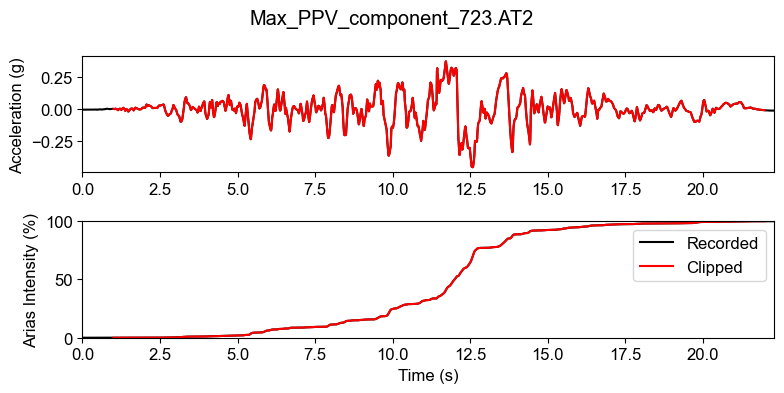

In [9]:
# plot acceleration time history 
# Specify the start and end times for clipping
start_time = 1
end_time = 22

dt = df['Time (s)'][1] - df['Time (s)'][0]
# Calculate the corresponding indices
start_index = int(start_time / dt)
end_index = int(end_time / dt)
df_clipped = df.iloc[start_index:end_index+1].copy()

fig, axs = plt.subplots(2, 1, figsize=(8, 4))
arias = arias_intensity(df['Time (s)'], df['Acceleration (g)'])
arias_clipped = arias_intensity(df_clipped['Time (s)'], df_clipped['Acceleration (g)'])
fig.suptitle(df.name)

# Plotting time series
axs[0].plot(df['Time (s)'], df['Acceleration (g)'],'k')
axs[0].plot(df_clipped['Time (s)'], df_clipped['Acceleration (g)'],'r')
axs[0].set(ylabel = 'Acceleration (g)')
axs[0].set_xlim(0,max(df['Time (s)']))
#plotting Husid plot
axs[1].plot(df['Time (s)'], arias,'k', label='Recorded')
axs[1].plot(df_clipped['Time (s)'], arias_clipped,'r', label='Clipped')
axs[1].set(xlabel = 'Time (s)', ylabel = 'Arias Intensity (%)')
axs[1].set_ylim(0,100)
axs[1].set_xlim(0,max(df['Time (s)']))
axs[1].legend()

plt.tight_layout()
plt.show()

**Step 2.2 (Optional):** Apply cosine taper to clipped record to eliminate abrupt onset or end of shaking. This code utilizes the ObsPy package (Krischer et al., 2015).

In [10]:
# Reset the time column to start from 0
df_clipped['Time (s)'] = np.arange(0, len(df_clipped) * dt, dt)
acceleration = df_clipped['Acceleration (g)'] * 9.81

#apply cosine taper
taper_percentage = 0.1 #10% tapers 5% from each end of the time history
taper = cosine_taper(len(acceleration), taper_percentage)
taper_acceleration = acceleration * taper

**Step 2.3 (Optional):** Apply a baseline correction to remove spurious baseline trends and prevent non-zero velocity after earthquake. This code uses the gmspy package (https://gmspy.readthedocs.io/en/latest/). For more information on baseline correction, refer to Boore (BSSA, 2001).

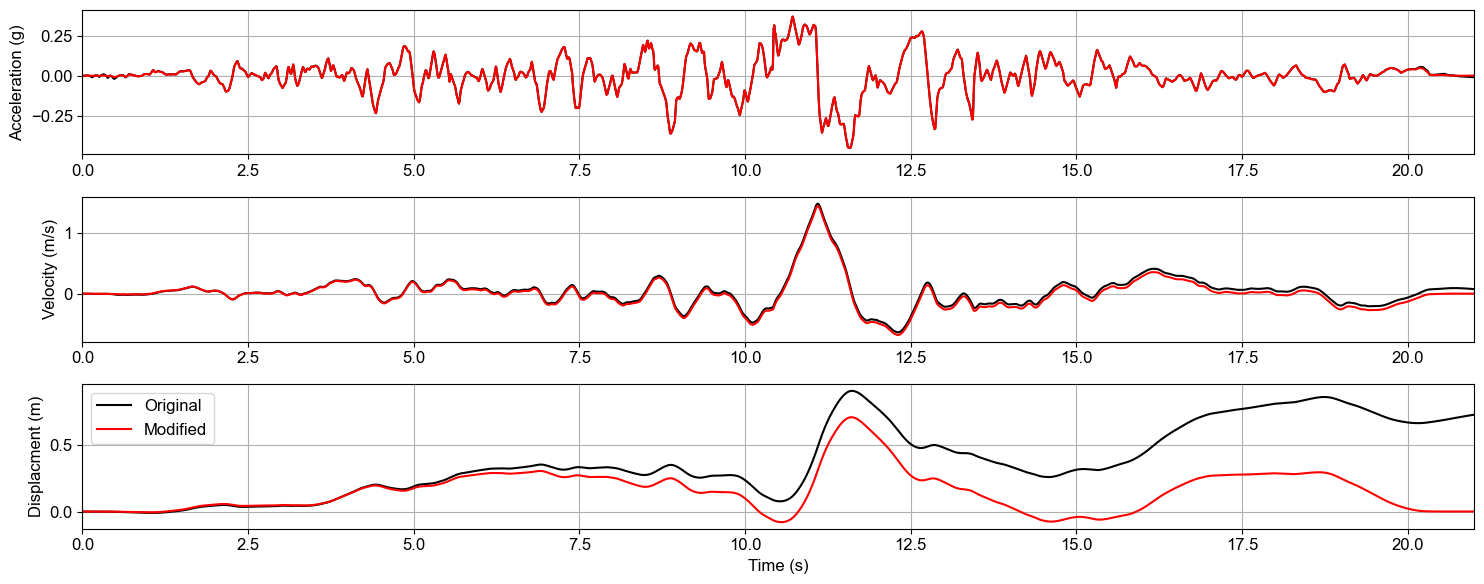

In [11]:
#apply baseline correction
corrected_acceleration = gm.baselinecorr(df_clipped['Time (s)'], taper_acceleration, poly_degree = 1)[0] # change poly_degree for quadractic or cubic baseline correction

# Integrate acceleration to get velocity
velocity = cumtrapz(acceleration, df_clipped['Time (s)'], initial=0)
corrected_velocity = cumtrapz(corrected_acceleration, df_clipped['Time (s)'], initial=0)

# Integrate velocity to get displacement
displacement = cumtrapz(velocity, df_clipped['Time (s)'], initial=0)
corrected_displacement = cumtrapz(corrected_velocity, df_clipped['Time (s)'], initial=0)

fig, axs = plt.subplots(3, 1, figsize=(15, 6))

# Plotting accelerations
axs[0].plot(df_clipped['Time (s)'], acceleration/9.81,'k', label = 'Original')
axs[0].plot(df_clipped['Time (s)'], corrected_acceleration/9.81,'r' , label = 'Modified')
axs[0].set(ylabel = 'Acceleration (g)')
axs[0].set_xlim(0,max(df_clipped['Time (s)']))
axs[0].grid()


# Plotting velocities
axs[1].plot(df_clipped['Time (s)'], velocity,'k', label = 'Original')
axs[1].plot(df_clipped['Time (s)'], corrected_velocity,'r', label = 'Modified')
axs[1].set(ylabel = 'Velocity (m/s)')
axs[1].set_xlim(0,max(df_clipped['Time (s)']))
axs[1].grid()

# Plotting displacements
axs[2].plot(df_clipped['Time (s)'], displacement,'k', label = 'Original')
axs[2].plot(df_clipped['Time (s)'], corrected_displacement,'r', label = 'Modified')
axs[2].set(ylabel = 'Displacment (m)', xlabel = 'Time (s)')
axs[2].set_xlim(0,max(df_clipped['Time (s)']))
axs[2].grid()

plt.tight_layout()
plt.legend()
plt.show()


**Step 3:** Format velocity time history as FLAC history and save. Note this procedure is for applying ground motions to a compliant base by converting
 the velocity time history to stress time history (Mejia and Dawson, 2006)

In [13]:
velocity_df = df_clipped.copy()  

velocity_df['velocity (m/s)'] = corrected_velocity

velocity_df = velocity_df['velocity (m/s)']
velocity_df.fillna(0, inplace=True)

# Define a custom format function
def format_scientific_notation(val):
    return f"{val:.2E}"

# Apply the format function to the 'velocity (m/s)' column
velocity_df = velocity_df.apply(format_scientific_notation)

info = f"{df.name.split('.')[0]} velocity (m/s)"
length = str(len(velocity_df)) + f'\t{dt}'
#save velocity time history
output_file_path = r'FLAC_input_files/' + df.name.split('.')[0] + '.txt'
with open(output_file_path, 'w') as f:
    f.write(info + '\n')
    f.write(length + '\n')
    values = velocity_df.tolist()
    f.write('\n'.join(values))
print(f"Velocity time history saved to {output_file_path}")

Velocity time history saved to FLAC_input_files/Max_PPV_component_723.txt
